# In this notebook we test the final performance of two different algorithms in an 8 class classification problem: Given an image of a car, what is its orientation? Front, Front-Left, Front-Right, Back, Back-Left, Back-Right, Left or Right.

### Algorithm 1 - A combination of a semantic segmentation network trained to segment different car parts (e.g front bumper, back left door, wheel etc.) and a deterministic ruleset we use which recieves detected classes (and some other data detailed in the DL Project Algorithm 1 notebook) and returns a classification. AVG inference time: 0.12 seconds per sample.

### Algorithm 2 - A CNN trained on the images labeled by Algorithm 1 (Labels were validated and changed if a wrong prediction was made). AVG inference time: 0.03 seconds per sample.

In [ ]:
import json 
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2DTranspose, concatenate
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import BatchNormalization, Add, Subtract, ReLU, Dropout
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the segmentation model

In [ ]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Segmentation model', custom_objects = {'MyMeanIOU' : MyMeanIOU(num_classes = 19)})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

# Load data

In [ ]:
original_car_data = np.load('/content/drive/MyDrive/Colab Notebooks/full_image_data.npy')
original_car_labels = np.load('/content/drive/MyDrive/Colab Notebooks/full_label_data.npy')
stanford_car_data = np.load('/content/drive/MyDrive/full_image_data_stanford.npy')
stanford_car_labels = np.load('/content/drive/MyDrive/full_label_data_stanford.npy')
berkley_car_data = np.load('/content/drive/MyDrive/Copy of full_image_data_berkley.npy')
berkley_car_labels = np.load('/content/drive/MyDrive/Copy of full_label_data_berkley.npy')


# Pre process data

In [ ]:
original_car_data = list(original_car_data)
stanford_car_data = list(stanford_car_data)
berkley_car_data = list(berkley_car_data)

for i in range(len(original_car_data)):
    original_car_data[i] = tf.image.resize(original_car_data[i], (128, 128))
     
for i in range(len(stanford_car_data)):
    stanford_car_data[i] = tf.image.resize(stanford_car_data[i], (128, 128))

for i in range(len(berkley_car_data)):
    berkley_car_data[i] = tf.image.resize(berkley_car_data[i], (128, 128))
    berkley_car_data[i] = berkley_car_data[i] / 255.0

In [ ]:
original_car_data = np.array(original_car_data)
stanford_car_data = np.array(stanford_car_data)
berkley_car_data = np.array(berkley_car_data)

# Testing our algorithm 

### We'll load the data and run out algorithm against the true labels and see how it performs

# Defining helper functions / variables

In [ ]:
classification_dict = {
     0 : 'front',
     1 : 'front-right',
     2 : 'right',
     3 : 'back-right',
     4 : 'back' ,
     5 : 'back-left',
     6 : 'left' ,
     7 : 'front-left'
}

rev_classification_dict = {v : k for k, v in classification_dict.items()}
rev_classification_dict

category_dict = {'_background_': 0,
 'back_bumper': 1,
 'back_glass': 2,
 'back_left_door': 3,
 'back_left_light': 4,
 'back_right_door': 5,
 'back_right_light': 6,
 'front_bumper': 7,
 'front_glass': 8,
 'front_left_door': 9,
 'front_left_light': 10,
 'front_right_door': 11,
 'front_right_light': 12,
 'hood': 13,
 'left_mirror': 14,
 'right_mirror': 15,
 'tailgate': 16,
 'trunk': 17,
 'wheel': 18}

rev_category_dict = {v : k for k, v in category_dict.items()}
category_dict

def get_prediction(model, image):
    return np.array(tf.math.argmax(model.predict(np.expand_dims(image, axis = 0)), axis = -1)[0, :, :])


In [ ]:
# Defining helper functions

def get_pixel_amnt(img, pixel_val):
    """
    Used the count the amount of pixels for a certain class (i.e wheel) in a prediction
    """
    ret = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == pixel_val:
                ret += 1
    return ret

def get_arr_mode(x):
    """
    Used to find majority class in segmentations
    """
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], counts[m]

def match_block_to_pred(pred, SLIC_pred):
    """
    Used to find the final prediction (by getting the majority class) for a given segment 
    of an image generated by SLIC
    """
    ret_img = np.zeros(SLIC_pred.shape)
    predicted_classes = []
    for val in np.unique(SLIC_pred):
        segment = (SLIC_pred == val)     
        majority_pred = get_arr_mode(pred[segment])[0]
        ret_img[segment] = majority_pred
        predicted_classes.append(rev_category_dict[majority_pred])
    
    return ret_img, set(predicted_classes)

def get_wheel_pred_mask(pred):
    """
    Return a mask for a given prediction where wheel was predicted
    """
    if not get_pixel_amnt(pred, category_dict['wheel']):
        return False
    return pred == category_dict['wheel']

def is_wheel_present(pred):
    """
    Heuristic to decide if a wheel is present in the image:
            "Wheel pixels are more than one precent of the non background pixels"
    """
    not_background_count = int(pred.shape[0] * pred.shape[1]) - get_pixel_amnt(pred, category_dict['_background_'])
    wheel_count = get_pixel_amnt(pred, category_dict['wheel'])
    if not wheel_count:
        return False
    if wheel_count / not_background_count >= 0.01:
        return True
    return False

def get_class_centroid(pred, val):
    """
    Finds the centroid of a given class in a given prediction, mainly used
    to detect if the wheel is to the left\right of the front\back of the car
    """
    y, x = np.where(pred == val)
    return np.mean(x), np.mean(y)


In [ ]:
# Defining main functions

def get_SLIC_prediction(model, data, n, segments_param, C_param, sigma_param, is_oop = False):
    """
    Function that recieves an input image, generates a prediction,
    applys SLIC segmentations to the image using given params, cleans up the 
    prediction noise by changing each segment to it's majority class, and returns
    the found classes and final 'cleaned up' prediction
    """
    if is_oop:
        pred = get_prediction(model, data[n].img)
    else:
        pred = get_prediction(model, data[n])
    wheel_flag = is_wheel_present(pred)
    img = plt.cm.tab20b(pred)[:, :, :-1]
    segments_slic = slic(img, n_segments = segments_param, compactness = C_param, sigma = sigma_param,
                     start_label = 1)
    final_pred, found_classes = match_block_to_pred(pred, segments_slic)

    return found_classes, wheel_flag, final_pred
 
def get_majority_side(side_1_lst, side_2_lst, pred):
    side_1_cnt = 0
    side_2_cnt = 0
    for cat in side_1_lst:
        side_1_cnt += get_pixel_amnt(pred, category_dict[cat])
    for cat in side_2_lst:
        side_2_cnt += get_pixel_amnt(pred, category_dict[cat])
    return side_1_lst if side_1_cnt > side_2_cnt else side_2_lst



def get_final_prediction(found_classes, wheel_flag, pred):
    """
    Gets input from get_SLIC_prediction, ruleset to decide which
    of the cars sides are visible
    """
    front = ['front_bumper', 'front_glass', 'hood']
    back = ['back_bumper', 'back_glass', 'tailgate', 'trunk']
    left = ['front_left_door', 'back_left_door']
    right = ['front_right_door', 'back_right_door']
    front_found = list(set(front) & set(found_classes))
    back_found = list(set(back) & set(found_classes))
    left_found = list(set(left) & set(found_classes))
    right_found = list(set(right) & set(found_classes))
    front_count = len(front_found)
    back_count = len(back_found)
    left_count = len(left_found)
    right_count = len(right_found)
    if front_count + back_count + left_count + right_count == 0 and wheel_flag:
        return 'back'

    if front_count == back_count and front_count != 0:
        if get_majority_side(front_found, back_found, pred) == front_found:
            front_visible = True
        else:
            front_visible = False
    else :
        front_visible = front_count > back_count 
    if wheel_flag:
        # If majority class is left or right
        if max(front_count, back_count, left_count, right_count) not in [front_count, back_count]: # meaning max group is a left or right
            if left_count == right_count and left_count != 0:
                # Since left and right are very similair, count pixels for each side and decide that way
                if get_majority_side(left_found, right_found, pred) == left_found:
                    return 'left'
                else:
                    return 'right'
            return 'left' if left_count > right_count else 'right'
        elif front_visible:
            # Since front bumper is usually visilbe and in a good postion, default to this center
            if 'front_bumper' in front_found:
                center_class = 'front_bumper'
            # If can't find front bumper, take other center
            else:
                center_class = front_found[0]
            front_centroid, wheel_centroid = get_class_centroid(pred, category_dict[center_class])[0] , get_class_centroid(pred, category_dict['wheel'])[0]
            if front_centroid < wheel_centroid:
                return 'front-left' 
            elif front_centroid >= wheel_centroid:
                return 'front-right'
        else: # front not visible but back is visible
            center_class = back_found[0] 
            back_centroid, wheel_centroid = get_class_centroid(pred, category_dict[center_class])[0] , get_class_centroid(pred, category_dict['wheel'])[0]
            if back_centroid < wheel_centroid:
                return 'back-right' 
            elif back_centroid >= wheel_centroid:
                return 'back-left'
    else: # wheel_flag is false
        return 'front' if front_count > back_count else 'back'
    return 'front'
            

In [ ]:
def show_wrong_pred(y_true, y_pred, dataset):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    wrong_idxs = np.flatnonzero(y_true != y_pred)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))
    for i in range(2):
        for j in range(2):    
            index = np.random.choice(wrong_idxs, 1, replace=False)
            axs[i][j].imshow(dataset[index][0])
            axs[i][j].title.set_text(f'predicted: {classification_dict[int(y_pred[index])]}, ground truth: {classification_dict[int(y_true[index])]}')

# Testing 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def accuracy_report(y_true, y_pred):
    print(f'accuracy: {accuracy_score(y_true, y_pred)}')
    print(classification_report(y_true, y_pred, target_names = list(classification_dict.values())))
    from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

    matrix = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(matrix, display_labels = classification_dict.values()).plot(ax=axes[0])
    axes[0].title.set_text('Full confusion matrix')

    np.fill_diagonal(matrix, 0)
    ConfusionMatrixDisplay(matrix, display_labels = classification_dict.values()).plot(ax=axes[1])
    axes[1].title.set_text('Confusion matrix - only wrong predictions')

    plt.tight_layout()  
    plt.show()


## Algorithm 1 On The Original segmentation data, accuracy = 86%.

### Note: ~400 of the images in this dataset we're used in the training and validation sets used to train the segmentation network so results might be postively skewed. Other datasets (Stanford and Berkley) were completely hidden to the segmentation model.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy: 0.8614457831325302
              precision    recall  f1-score   support

       front       0.94      0.82      0.88       138
 front-right       0.89      0.90      0.90        63
       right       0.89      0.89      0.89        44
  back-right       0.58      0.88      0.70        24
        back       0.98      0.68      0.80        60
   back-left       0.73      0.86      0.79        28
        left       0.92      0.94      0.93        51
  front-left       0.80      0.96      0.87        90

    accuracy                           0.86       498
   macro avg       0.84      0.87      0.84       498
weighted avg       0.88      0.86      0.86       498



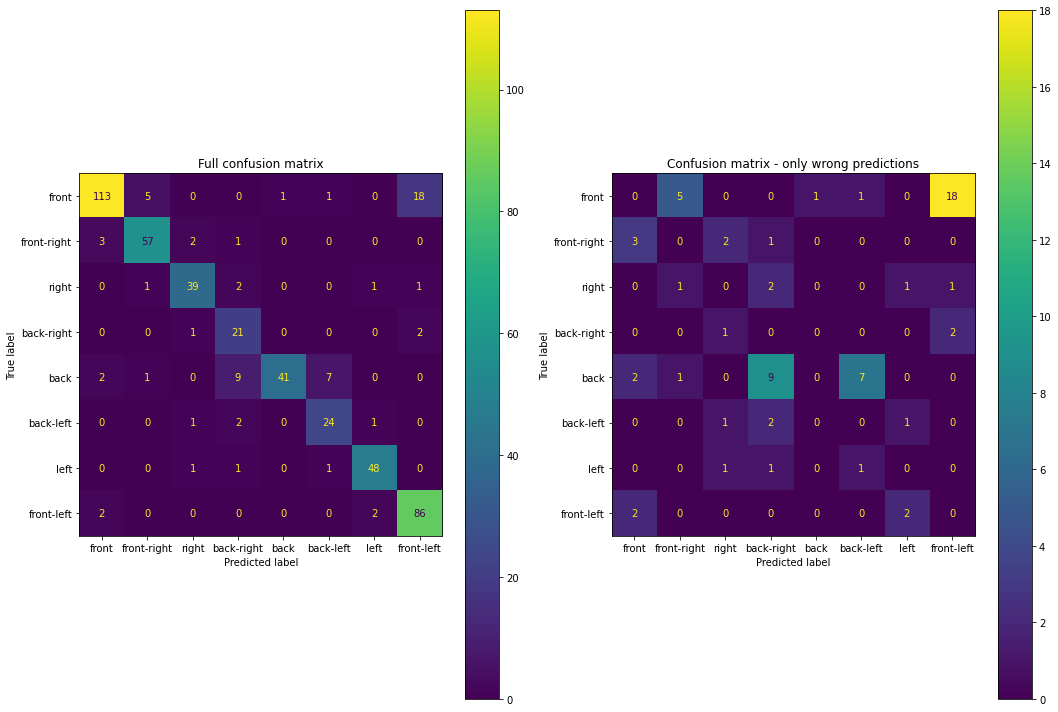

In [ ]:
preds = []
for i in range(len(original_car_data)):
    preds.append(rev_classification_dict[get_final_prediction(*get_SLIC_prediction(model, original_car_data, i, 150, 1, 1, False))])

accuracy_report(original_car_labels, preds)

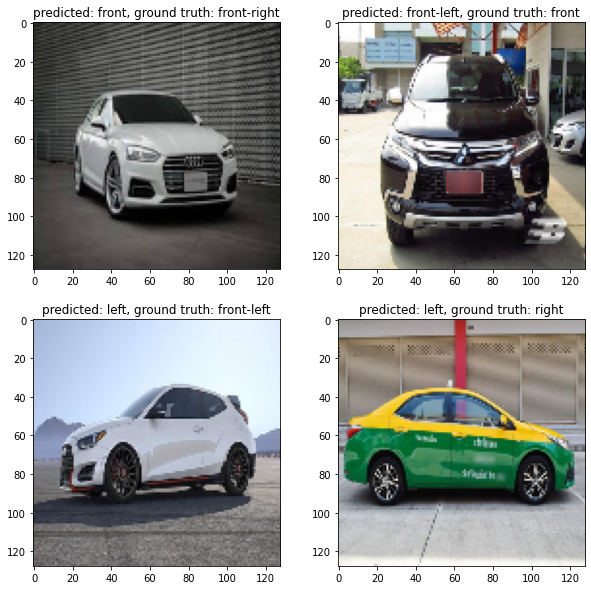

In [ ]:
show_wrong_pred(original_car_labels, preds, original_car_data)

# Algorithm 1 On The Stanford Dataset, accuracy = 74%

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy: 0.7371007371007371
              precision    recall  f1-score   support

       front       0.46      0.50      0.48        34
 front-right       0.91      0.75      0.83       114
       right       0.50      0.90      0.64        21
  back-right       0.58      0.47      0.52        32
        back       0.22      0.20      0.21        10
   back-left       0.78      0.70      0.74        30
        left       0.47      0.88      0.61        24
  front-left       0.91      0.84      0.87       142

    accuracy                           0.74       407
   macro avg       0.60      0.66      0.61       407
weighted avg       0.77      0.74      0.75       407



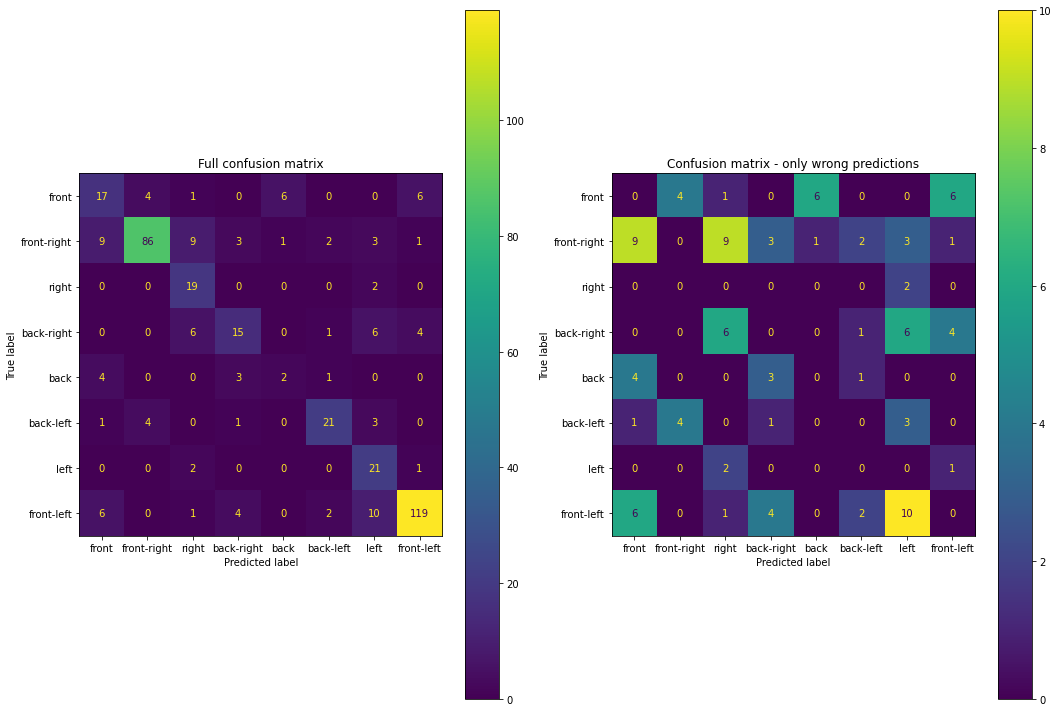

In [ ]:
stanford_preds = []
for i in range(len(stanford_car_data)):
    stanford_preds.append(rev_classification_dict[get_final_prediction(*get_SLIC_prediction(model, stanford_car_data, i, 150, 1, 1, False))])
accuracy_report(stanford_car_labels, stanford_preds)

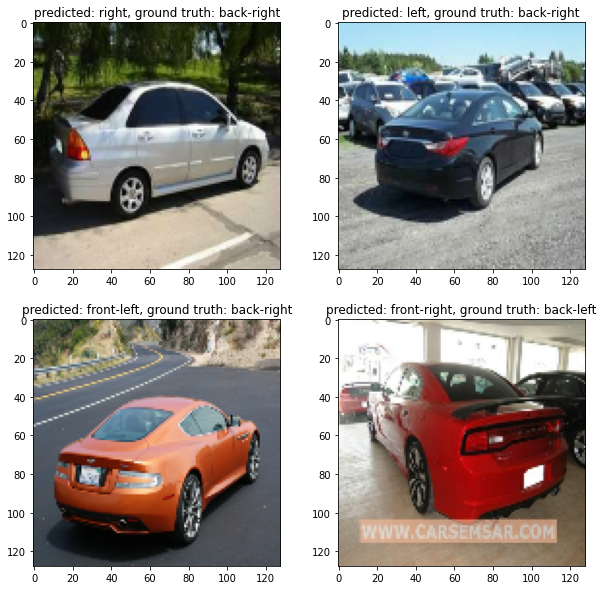

In [ ]:
show_wrong_pred(stanford_car_labels, stanford_preds, stanford_car_data)

# Algorithm 1 On The Berkley Dataset, accuracy = 42%.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy: 0.4174757281553398
              precision    recall  f1-score   support

       front       0.02      0.29      0.04         7
 front-right       0.07      0.33      0.11         3
       right       0.50      0.11      0.17        19
  back-right       0.57      0.39      0.47        89
        back       0.47      0.79      0.59       145
   back-left       0.62      0.32      0.42       137
        left       0.31      0.06      0.10        70
  front-left       0.52      0.29      0.37        45

    accuracy                           0.42       515
   macro avg       0.38      0.32      0.28       515
weighted avg       0.50      0.42      0.41       515



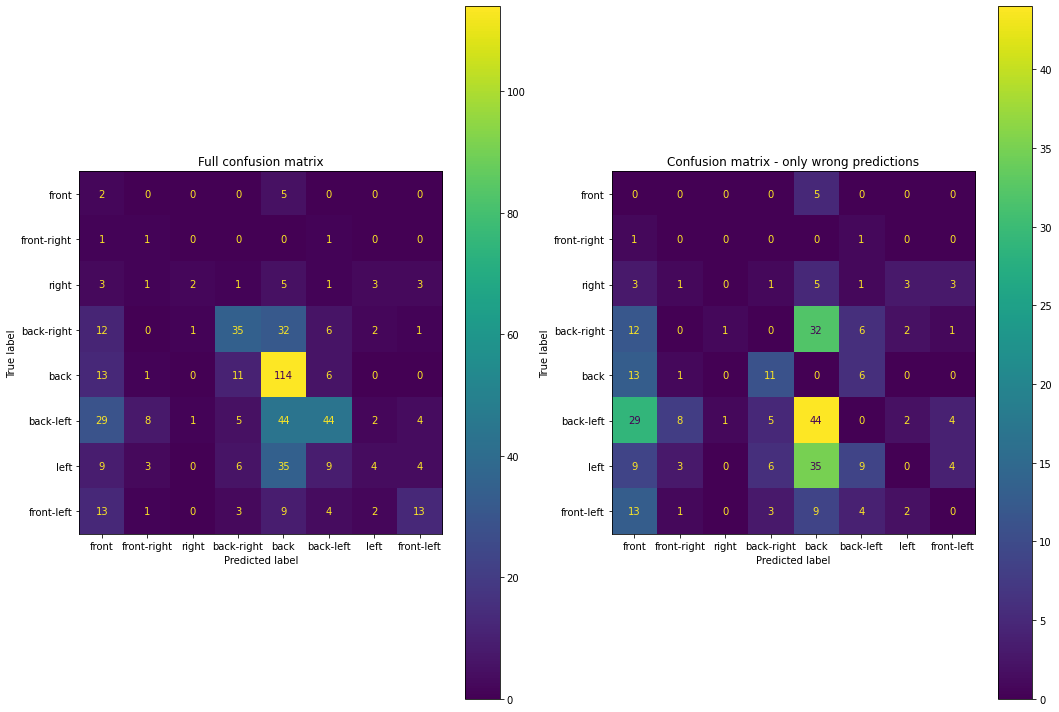

In [ ]:
berkley_preds = []
for i in range(len(berkley_car_data)):
    berkley_preds.append(rev_classification_dict[get_final_prediction(*get_SLIC_prediction(model, berkley_car_data, i, 150, 1, 1, False))])
accuracy_report(berkley_car_labels, berkley_preds)

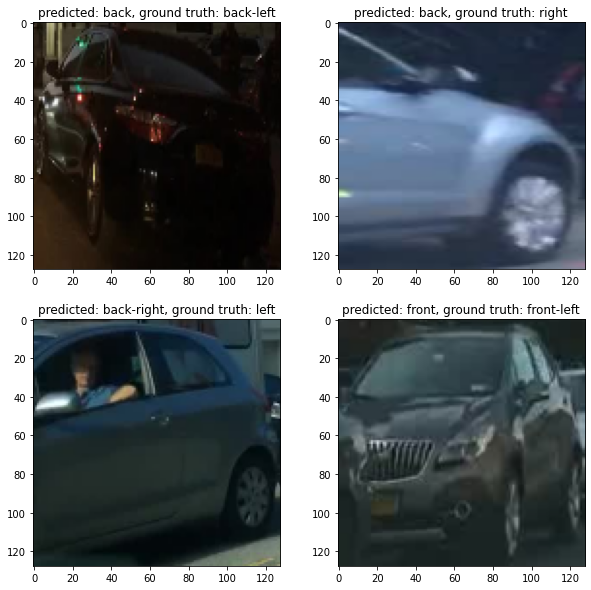

In [ ]:
show_wrong_pred(berkley_car_labels, berkley_preds, berkley_car_data)

# Checking results of the CNN Model

In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN Model')
cnn_model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_192 (MaxPooli  (None, 63, 63, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_161 (Ba  (None, 63, 63, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_202 (Conv2D)         (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_193 (MaxPooli  (None, 30, 30, 64)       0         
 ng2D)                                                           
                                                     

## We'll seperate the data into the train test split validation the model was trained on to check test set performance

In [ ]:
# Seperate into train test validation wit

# original_car_data:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(original_car_data, original_car_labels):  
    X_train_original, X_test_original = original_car_data[train_index], original_car_data[test_index]
    y_train_original, y_test_original = original_car_labels[train_index], original_car_labels[test_index]

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(X_train_original, y_train_original):  
    X_train_original, X_val_original = X_train_original[train_index], X_train_original[test_index]
    y_train_original, y_val_original = y_train_original[train_index], y_train_original[test_index]

print('Shape of original X_train is:', X_train_original.shape)
print('Shape of original y_train is:', y_train_original.shape)
print('Shape of original X_test is:', X_test_original.shape)
print('Shape of original y_test is:', y_test_original.shape)
print('Shape of original X_val is:', X_val_original.shape)
print('Shape of original y_val is:', y_val_original.shape)
print('\n')

# stanford car data:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(stanford_car_data, stanford_car_labels):  
    X_train_stanford, X_test_stanford = stanford_car_data[train_index], stanford_car_data[test_index]
    y_train_stanford, y_test_stanford = stanford_car_labels[train_index], stanford_car_labels[test_index]

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(X_train_stanford, y_train_stanford):  
    X_train_stanford, X_val_stanford = X_train_stanford[train_index], X_train_stanford[test_index]
    y_train_stanford, y_val_stanford = y_train_stanford[train_index], y_train_stanford[test_index]

print('Shape of stanford X_train is:', X_train_stanford.shape)
print('Shape of stanford y_train is:', y_train_stanford.shape)
print('Shape of stanford X_test is:', X_test_stanford.shape)
print('Shape of stanford y_test is:', y_test_stanford.shape)
print('Shape of stanford X_val is:', X_val_stanford.shape)
print('Shape of stanford y_val is:', y_val_stanford.shape)
print('\n')

# berkley car data:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(berkley_car_data, berkley_car_labels):  
    X_train_berkley, X_test_berkley = berkley_car_data[train_index], berkley_car_data[test_index]
    y_train_berkley, y_test_berkley = berkley_car_labels[train_index], berkley_car_labels[test_index]

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in sss.split(X_train_berkley, y_train_berkley):  
    X_train_berkley, X_val_berkley = X_train_berkley[train_index], X_train_berkley[test_index]
    y_train_berkley, y_val_berkley = y_train_berkley[train_index], y_train_berkley[test_index]

print('Shape of berkley X_train is:', X_train_berkley.shape)
print('Shape of berkley y_train is:', y_train_berkley.shape)
print('Shape of berkley X_test is:', X_test_berkley.shape)
print('Shape of berkley y_test is:', y_test_berkley.shape)
print('Shape of berkley X_val is:', X_val_berkley.shape)
print('Shape of berkley y_val is:', y_val_berkley.shape)

Shape of original X_train is: (318, 128, 128, 3)
Shape of original y_train is: (318,)
Shape of original X_test is: (100, 128, 128, 3)
Shape of original y_test is: (100,)
Shape of original X_val is: (80, 128, 128, 3)
Shape of original y_val is: (80,)


Shape of stanford X_train is: (260, 128, 128, 3)
Shape of stanford y_train is: (260,)
Shape of stanford X_test is: (82, 128, 128, 3)
Shape of stanford y_test is: (82,)
Shape of stanford X_val is: (65, 128, 128, 3)
Shape of stanford y_val is: (65,)


Shape of berkley X_train is: (329, 128, 128, 3)
Shape of berkley y_train is: (329,)
Shape of berkley X_test is: (103, 128, 128, 3)
Shape of berkley y_test is: (103,)
Shape of berkley X_val is: (83, 128, 128, 3)
Shape of berkley y_val is: (83,)


In [ ]:
def get_cnn_accuracy(data, labels):
    temp = []
    for i in range(len(data)):
        temp.append(np.argmax(cnn_model(data[i][None, :, :, :])))
    return accuracy_score(labels, temp)


# Algorithm 2 (CNN) On The Original Segmentation Images, accuracy = 88%.

accuracy: 0.88
              precision    recall  f1-score   support

       front       0.96      0.86      0.91        28
 front-right       0.87      1.00      0.93        13
       right       1.00      1.00      1.00         9
  back-right       0.80      0.80      0.80         5
        back       0.80      0.67      0.73        12
   back-left       0.57      0.80      0.67         5
        left       0.91      1.00      0.95        10
  front-left       0.89      0.89      0.89        18

    accuracy                           0.88       100
   macro avg       0.85      0.88      0.86       100
weighted avg       0.89      0.88      0.88       100



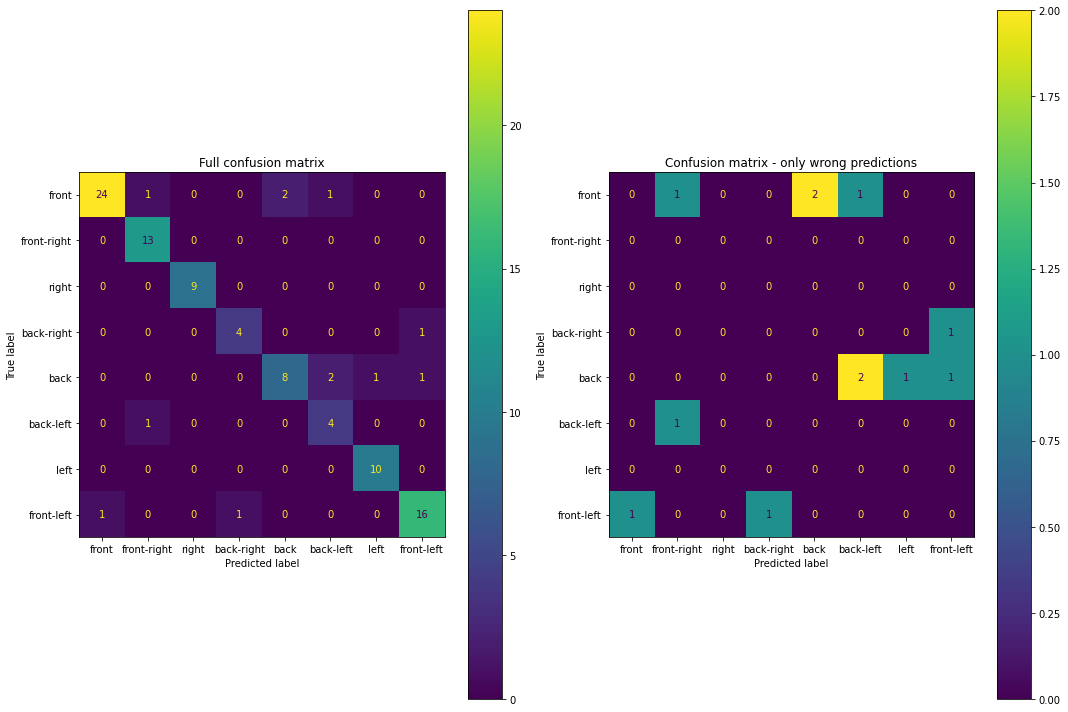

In [ ]:
cnn_preds = []

for i in range(len(X_test_original)):
    cnn_preds.append(np.argmax(cnn_model(X_test_original[i][None, :, :, :])))

accuracy_report(y_test_original, cnn_preds)

In [ ]:
print(f'Original Train accuracy is {get_cnn_accuracy(X_train_original, y_train_original)}')
print(f'Original Validation accuracy is {get_cnn_accuracy(X_val_original, y_val_original)}')

Original Train accuracy is 0.9968553459119497
Original Validation accuracy is 0.9375


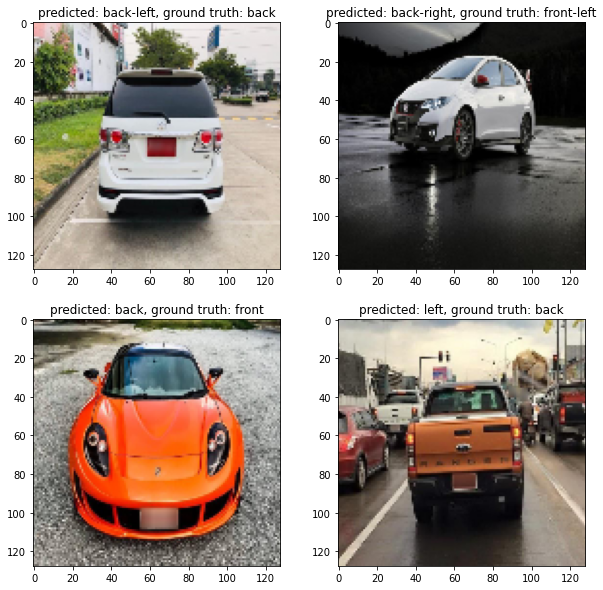

In [ ]:
show_wrong_pred(y_test_original, cnn_preds, X_test_original)

# Algorithm 2 (CNN) On The Stanford Dataset, accuracy = 74%.

accuracy: 0.7439024390243902
              precision    recall  f1-score   support

       front       0.80      0.57      0.67         7
 front-right       0.90      0.83      0.86        23
       right       0.60      0.75      0.67         4
  back-right       0.56      0.83      0.67         6
        back       0.67      1.00      0.80         2
   back-left       0.38      0.83      0.53         6
        left       0.75      0.60      0.67         5
  front-left       0.91      0.69      0.78        29

    accuracy                           0.74        82
   macro avg       0.70      0.76      0.71        82
weighted avg       0.80      0.74      0.76        82



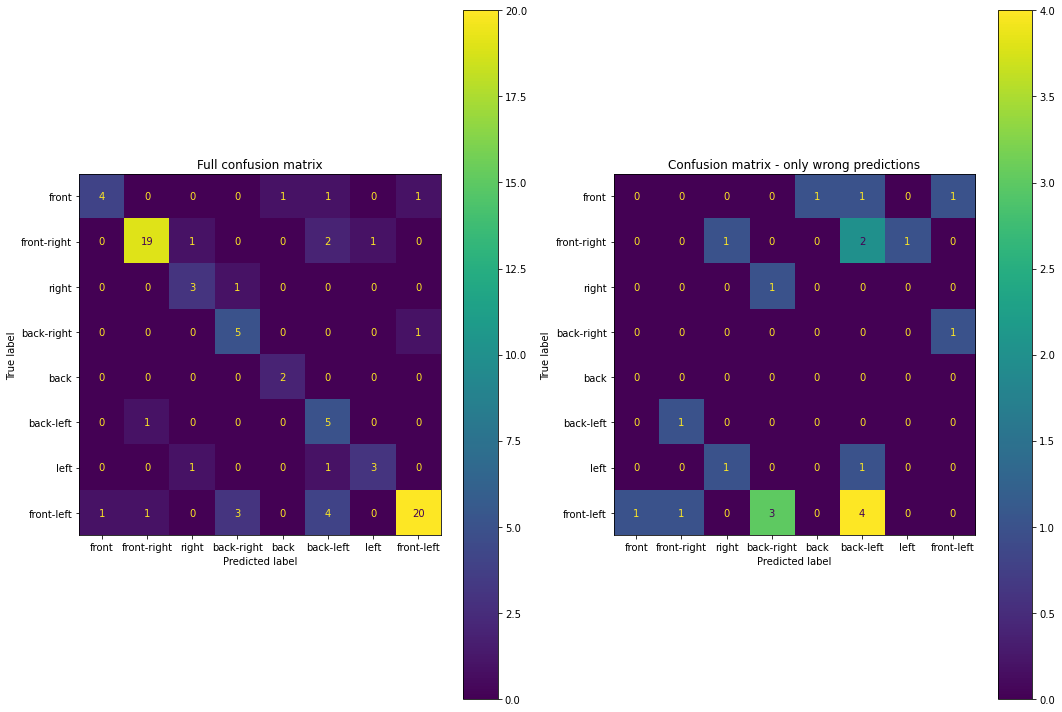

In [ ]:
stanford_cnn_preds = []
for i in range(len(X_test_stanford)):
    stanford_cnn_preds.append(np.argmax(cnn_model(X_test_stanford[i][None, :, :, :])))

accuracy_report(y_test_stanford, stanford_cnn_preds)

In [ ]:
print(f'Original Train accuracy is {get_cnn_accuracy(X_train_stanford, y_train_stanford)}')
print(f'Original Validation accuracy is {get_cnn_accuracy(X_val_stanford, y_val_stanford)}')

Original Train accuracy is 0.9961538461538462
Original Validation accuracy is 0.8


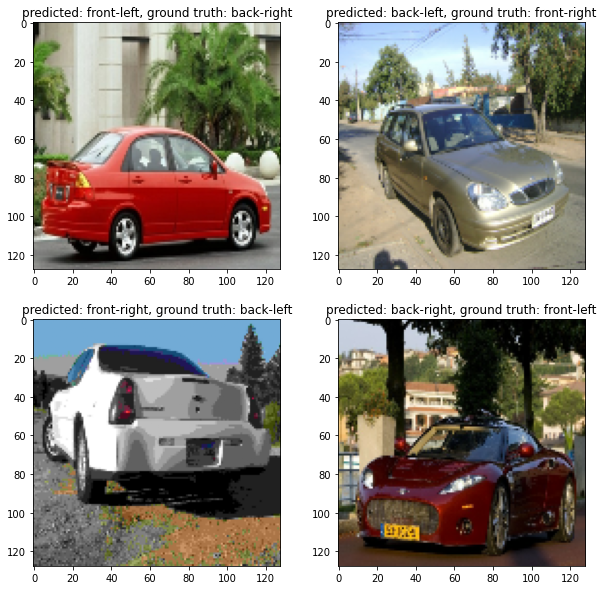

In [ ]:
show_wrong_pred(y_test_stanford, stanford_cnn_preds, X_test_stanford)

# Algorithm 2 (CNN) On The Berkley Dataset, accuracy = 74%.

accuracy: 0.7378640776699029
              precision    recall  f1-score   support

       front       0.00      0.00      0.00         1
 front-right       0.00      0.00      0.00         1
       right       1.00      0.25      0.40         4
  back-right       0.67      0.67      0.67        18
        back       0.88      0.76      0.81        29
   back-left       0.77      0.89      0.83        27
        left       0.75      0.64      0.69        14
  front-left       0.50      0.89      0.64         9

    accuracy                           0.74       103
   macro avg       0.57      0.51      0.51       103
weighted avg       0.75      0.74      0.73       103



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


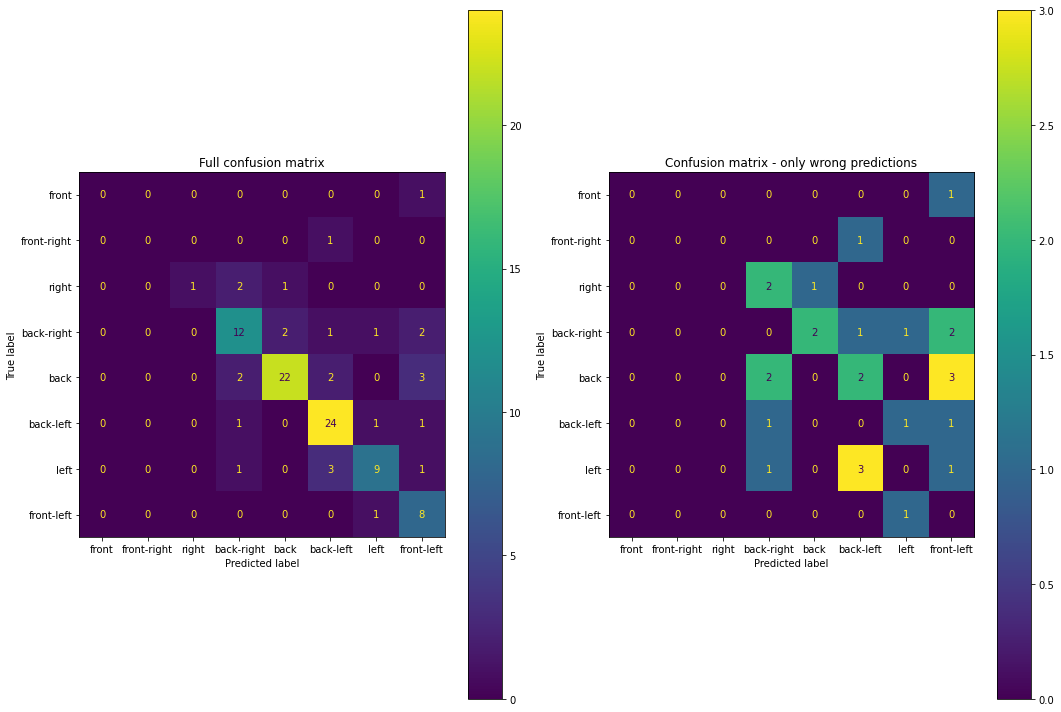

In [ ]:
berkley_cnn_preds = []
for i in range(len(X_test_berkley)):
    berkley_cnn_preds.append(np.argmax(cnn_model(X_test_berkley[i][None, :, :, :])))

accuracy_report(y_test_berkley, berkley_cnn_preds)

In [ ]:
print(f'Original Train accuracy is {get_cnn_accuracy(X_train_berkley, y_train_berkley)}')
print(f'Original Validation accuracy is {get_cnn_accuracy(X_val_berkley, y_val_berkley)}')

Original Train accuracy is 0.9726443768996961
Original Validation accuracy is 0.6385542168674698


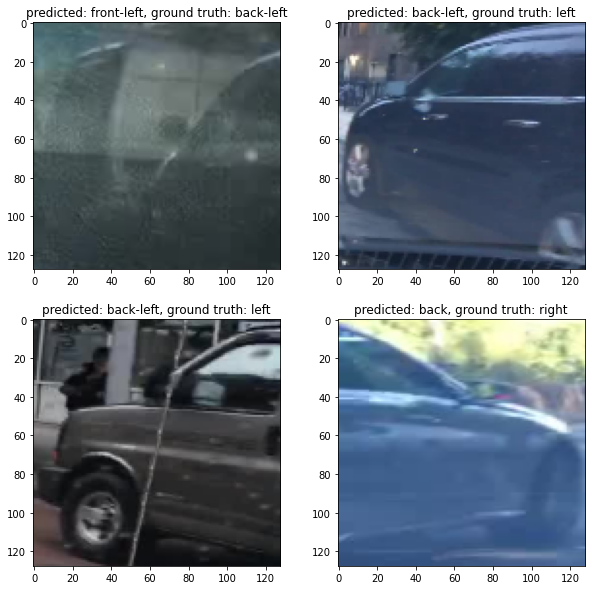

In [ ]:
show_wrong_pred(y_test_berkley, berkley_cnn_preds, X_test_berkley)

# Results Summary



### Algorithm 1:
			Orginal Segmentation Dataset: 86% accuracy 
			Stanford Cars Dataset: 74% accuracy
			Berkley Dataset: 42% accuracy
			Overall Accuracy: ~67.3%
            AVG Inference time: 0.12s


### Algorithm 2:
			Original Segmentation Dataset: 99.65% / 93.75% / 88% accuracy on the training / validation / testing sets respectively
			Stanford Cars Dataset: 99.61% / 80% / 74% accuracy on the training / validation / testing sets respectively
			Berkley Dataset: 97.26% / 63.85% / 74% accuracy on the training / validation / testing sets respectively
			Overall accuracy: 98.84% / 79.2% / 78.7% overall accuracy on the training / validation / testing sets respectively 
            AVG Inference time: 0.03s